In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf


In [2]:
cd ..

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations


In [3]:
from utils import plotting as pplot
from utils import rf_utils as rfutils
from utils import gratings_utils as gutils
from utils import roi_utils as roiutils
from utils import retino_utils as retutils
from utils import aggregate_datasets as aggr
from utils import helpers as hutils

In [4]:
%matplotlib notebook

In [5]:
import allensdk as ak

# Source

In [6]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'

traceid = 'traces001'
response_type='dff'
responsive_test='nstds'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=1000
n_resamples=20

print(responsive_test, responsive_thr)

nstds 10.0


# Plotting

In [7]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

# Aggregate meta 

In [8]:
importlib.reload(aggr)

<module 'utils.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [9]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,11,11,11
V1,9,9,9


In [10]:
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# Output dir

In [11]:
dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
                       '%s-%s' % (traceid, ori_fit_desc))
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# All fits

In [12]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, fit_desc=ori_fit_desc,
                             return_missing=True) 
gdata = hutils.split_datakey(gdata)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


In [13]:
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
gdata.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,visual_area,datakey,animalid,fov,session,tf
0,0.528705,0.524802,0.025275,-0.010931,0.038352,52.129545,0.000000,0.727584,160.0,0.365496,0.376922,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0
1,0.341041,0.685649,0.020652,-0.017558,0.059309,53.811532,132.244898,0.793545,170.0,0.323455,0.397306,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0
2,0.590751,0.679958,0.009313,-0.001160,0.027233,39.562740,352.653061,0.892822,172.0,0.899031,0.765403,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0
3,0.241354,0.572965,0.024139,-0.021777,0.047835,69.826945,227.755102,0.671892,177.0,0.660583,0.458513,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0
4,0.407956,0.362389,0.017694,-0.012919,0.037090,70.338493,80.816327,0.603767,178.0,0.327887,0.230345,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314,1.0


In [14]:
gdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,15
Lm,10
V1,9


In [15]:
gdata[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,261,261
Lm,619,619
V1,686,686


In [16]:
gdata[gdata['r2comb']>=0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,160,160
Lm,422,422
V1,492,492


# All data

In [17]:
importlib.reload(aggr)

<module 'utils.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [18]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, verbose=False,
                      responsive_thr=responsive_thr, n_stds=n_stds)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
20190314_JC070_fov1
20190315_JC070_fov2
20190319_JC067_fov1
20190522_JC089_fov1
20190527_JC092_fov3
20190602_JC091_fov1
20190606_JC091_fov1
20190607_JC091_fov1
20190609_JC099_fov1
20190612_JC099_fov1
20190614_JC091_fov1
20190617_JC099_fov1
20191018_JC113_fov1
20191105_JC117_fov1
20191111_JC120_fov1
20190306_JC061_fov2
20190314_JC070_fov2
20190512_JC083_fov1
20190513_JC078_fov1
20190517_JC083_fov1
20190525_JC084_fov1
20190603_JC080_fov1
20190618_JC097_fov1
20190627_JC091_fov1
20191105_JC117_fov1
20191111_JC120_fov1
20190511_JC083_fov1
20190512_JC083_fov1
20190517_JC083_fov1
20190522_JC084_fov1
20190613_JC097_fov1
20190616_JC097_fov1
20190617_JC097_fov1
20190622_JC085_fov1
20191006_JC110_fov1


#### Filter fits

In [190]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
        .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,datakey,animalid,fov,session,tf
visual_area,,,,,,,,,,,,,,,,,,,
Li,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261
Lm,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619,619
V1,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686,686


In [191]:
# old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
# bestg = p3.split_datakey(bestg)
# bestg = bestg[~bestg.animalid.isin(old_rats)]
# bestg[bestg.visual_area=='Li']['datakey']

In [200]:
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = list(tested_thetas.copy())
theta_vals.append(360)
theta_vals = np.array(theta_vals)
bestg['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)== np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in bestg['theta_pref'].values]
bestg['tested_theta'] = bestg['tested_theta'].astype(float)

In [201]:
bestg.groupby(['tested_theta']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,visual_area,datakey,animalid,fov,session,tf
tested_theta,,,,,,,,,,,,,,,,,,,,
0.0,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229
45.0,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179,179
90.0,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263
135.0,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165
180.0,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177,177
225.0,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165
270.0,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283,283
315.0,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105


In [202]:
fit_thr=0.50
counts = bestg[bestg['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)
NDATA1 = pd.concat([g for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,316,316
Lm,734,734
V1,825,825


In [194]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()


# Aggregate metrics

In [26]:
%matplotlib notebook

In [24]:
#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


### Signal corrs

In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [97]:
def calculate_signal_correlations(tuning_):
    '''
    tuning_ (pd.DataFrame): nconds x nrois -- unstack NDATA for easy column-wise ops.
    Each entry is the mean response (across trials) for a given stim condition.
    '''
    # Calculate signal corrs
    corrs_ = {}
    rois_ = [i for i in tuning_.columns if hutils.isnumber(i)]
    # Get unique pairs, then iterate thru and calculate pearson's CC
    for col_a, col_b in itertools.combinations(rois_, 2):
        corrs_['%i_%i' % (col_a, col_b)] = spstats.pearsonr(tuning_[col_a], 
                                                             tuning_[col_b])
    signal_corrs = pd.DataFrame.from_dict(corrs_, orient='index')
    signal_corrs.columns = ['p_cc', 'p_value']
    signal_corrs['cell_1'] = [int(r.split('_')[0]) for r in signal_corrs.index]
    signal_corrs['cell_2'] = [int(r.split('_')[1]) for r in signal_corrs.index]
    signal_corrs['neuron_pair'] = signal_corrs.index

    return signal_corrs

def calculate_noise_correlations(zscored_):
    '''
    tuning_ (pd.DataFrame): nconds x nrois -- unstack NDATA for easy column-wise ops.
    Each entry is the mean response (across trials) for a given stim condition.
    '''
    # Calculate noise corrs: Pearson correlation of the single-trial 
    # stimulus responses for a pair of neurons & a given stimulus.
    # Then, average over stimuli later.
    corrs_ = {}
    rois_ = [i for i in zscored.columns if hutils.isnumber(i)]
    # Get unique pairs, then iterate thru and calculate pearson's CC
    for cfg, g in zscored.groupby(['config']):
        for col_a, col_b in itertools.combinations(rois_, 2):
            r, p = spstats.pearsonr(g[col_a], g[col_b])
            corrs_['%i_%i_%s' % (col_a, col_b, cfg)]  = (r, p, cfg)
    noise_corrs = pd.DataFrame.from_dict(corrs_, orient='index')
    noise_corrs.columns = ['p_cc', 'p_value', 'config']
    noise_corrs['cell_1'] = [int(r.split('_')[0]) for r in noise_corrs.index]
    noise_corrs['cell_2'] = [int(r.split('_')[1]) for r in noise_corrs.index]
    noise_corrs['config'] = [r.split('_')[2] for r in noise_corrs.index]
    noise_corrs['neuron_pair'] = [(r.split('_config')[0]) for r in noise_corrs.index]
    
    return noise_corrs

#### Example FOV & CELL

In [35]:
va = 'V1'
dk='20190617_JC097_fov1'
selective_only=False

ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# Select cells
if selective_only:
    curr_cells = passg[(passg.visual_area==va) 
                    & (passg.datakey==dk)]['cell'].unique()
    if len(curr_cells)<5:
        print("Skipping.")
        #continue
else:
    curr_cells = ndf['cell'].unique()
# Select stimuli and trials
sdf = aggr.get_stimuli(dk, experiment='gratings')
cfgs = sdf.index.tolist()
ndf1 = ndf[(ndf.config.isin(cfgs)) & (ndf['cell'].isin(curr_cells))].copy()
# Reshape dataframe to ntrials x nrois
trial_means0 = aggr.stacked_neuraldf_to_unstacked(ndf1)
cfgs_by_trial = trial_means0['config']
# Zscore trials
zscored = aggr.zscore_dataframe(trial_means0[curr_cells])
zscored['config'] = cfgs_by_trial

In [98]:
# Get mean response per condition
tuning_ = zscored.groupby(['config']).mean().reset_index()
# Get signal corrs
signal_corrs = calculate_signal_correlations(tuning_)
# Get Noise correlations
noise_corrs0 = calculate_noise_correlations(zscored)
# Average over stimulus conditions 
noise_corrs = noise_corrs0.groupby(['neuron_pair']).mean().reset_index()

In [225]:
def calculate_signal_corrs2(g_mat, included_configs=None):
    if included_configs is None:
        included_configs = g_mat['config'].unique()
        
    tuning_ = g_mat[g_mat['config'].isin(included_configs)].groupby(['config']).mean().reset_index()
    cc = melt_square_matrix(tuning_.corr(), metric_name='signal_cc', include_diagonal=False)
    
    return cc

def melt_square_matrix(df, metric_name='value', add_values={}, include_diagonal=False):

    k = 0 if include_diagonal else 1
    df = df.where(np.triu(np.ones(df.shape), k=k).astype(np.bool))

    df = df.stack().reset_index()
    df.columns=['row', 'col', metric_name]

    if len(add_values) > 0:
        for k, v in add_values.items():
            df[k] = [v for _ in np.arange(0, df.shape[0])]

    return df


In [226]:
included_configs = sdf.index.tolist()

# true
g_mat = aggr.stacked_neuraldf_to_unstacked(ndf)
g_mat.columns = g_mat.columns.tolist()
cc = calculate_signal_corrs2(g_mat, included_configs=included_configs)

In [227]:
cc.head()

,row,col,signal_cc
0,0,1,0.849871
1,0,2,0.118115
2,0,3,0.431909
3,0,5,-0.031312
4,0,20,0.138621


In [228]:
signal_corrs

,p_cc,p_value,cell_1,cell_2,neuron_pair
0_1,0.849871,6.665869e-19,0,1,0_1
0_2,0.118115,3.526014e-01,0,2,0_2
0_3,0.431909,3.656979e-04,0,3,0_3
0_5,-0.031312,8.059779e-01,0,5,0_5
0_20,0.138621,2.746611e-01,0,20,0_20
...,...,...,...,...,...
399_430,0.398678,1.102466e-03,399,430,399_430
399_435,0.464558,1.101550e-04,399,435,399_435
428_430,0.675961,8.852131e-10,428,430,428_430
428_435,0.567078,1.031668e-06,428,435,428_435


#### Representational Similarity Matrix

<IPython.core.display.Javascript object>


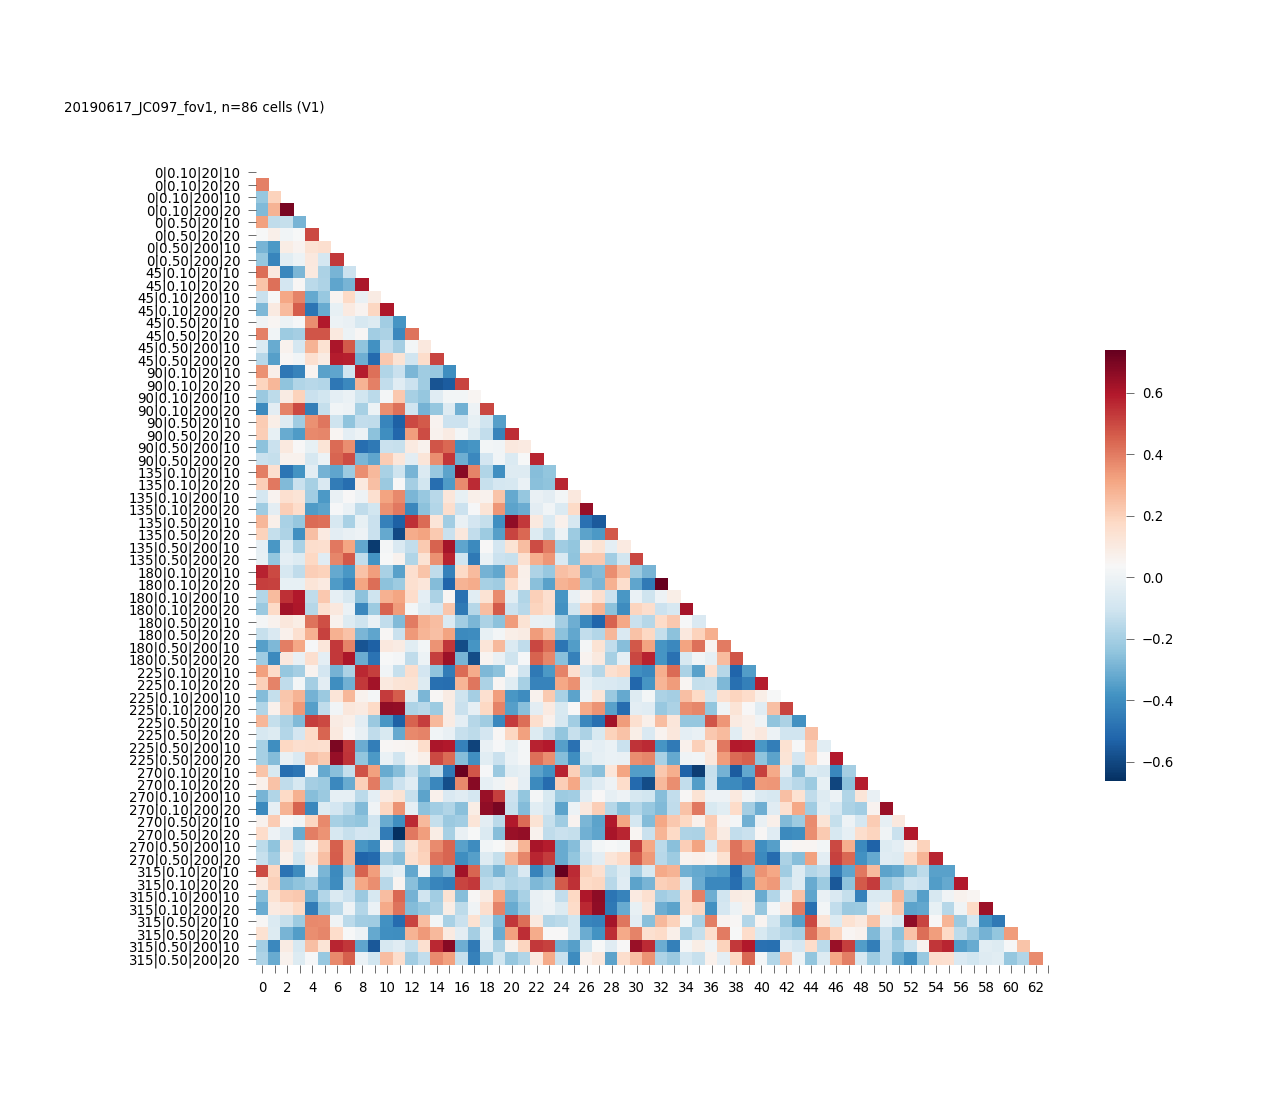

Text(0.05, 0.9, '20190617_JC097_fov1, n=86 cells (V1)')

In [179]:
sdf['tf'] = sdf['sf']*sdf['speed']
xlabels = ['%i|%.2f|%i|%i' % (o, sf, sz, sp) for (o, sf, sz, sp) in \
           sdf.loc[tuning_['config']][['ori', 'sf', 'size', 'speed']].values]

rmat = tuning_[rois_].T.corr(method='spearman')
mask = np.triu(np.ones_like(rmat, dtype=bool))

fig, ax = pl.subplots(figsize=(8,7))
sns.heatmap(rmat, mask=mask, cmap='RdBu_r', square=True, cbar_kws={"shrink": 0.5})
ax.set_yticks(np.array(range(64))+0.5)
ax.set_xticks(np.array(range(64))+0.5)
ax.set_yticklabels(xlabels, rotation=0)
#ax.set_aspect('equal')
pl.subplots_adjust(left=0.2, right=0.98)
fig.text(0.05, 0.9, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

#### Distributions of Signal and Noise Correlations

In [203]:
currfits = passg[(passg.visual_area==va) & (passg.datakey==dk)].copy()

sorter=['gof', 'r2comb']
top5 = currfits.sort_values(by=sorter, ascending=False)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:5]['cell'].values
bottom5 = currfits.sort_values(by=sorter, ascending=True)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:5]['cell'].values

<IPython.core.display.Javascript object>


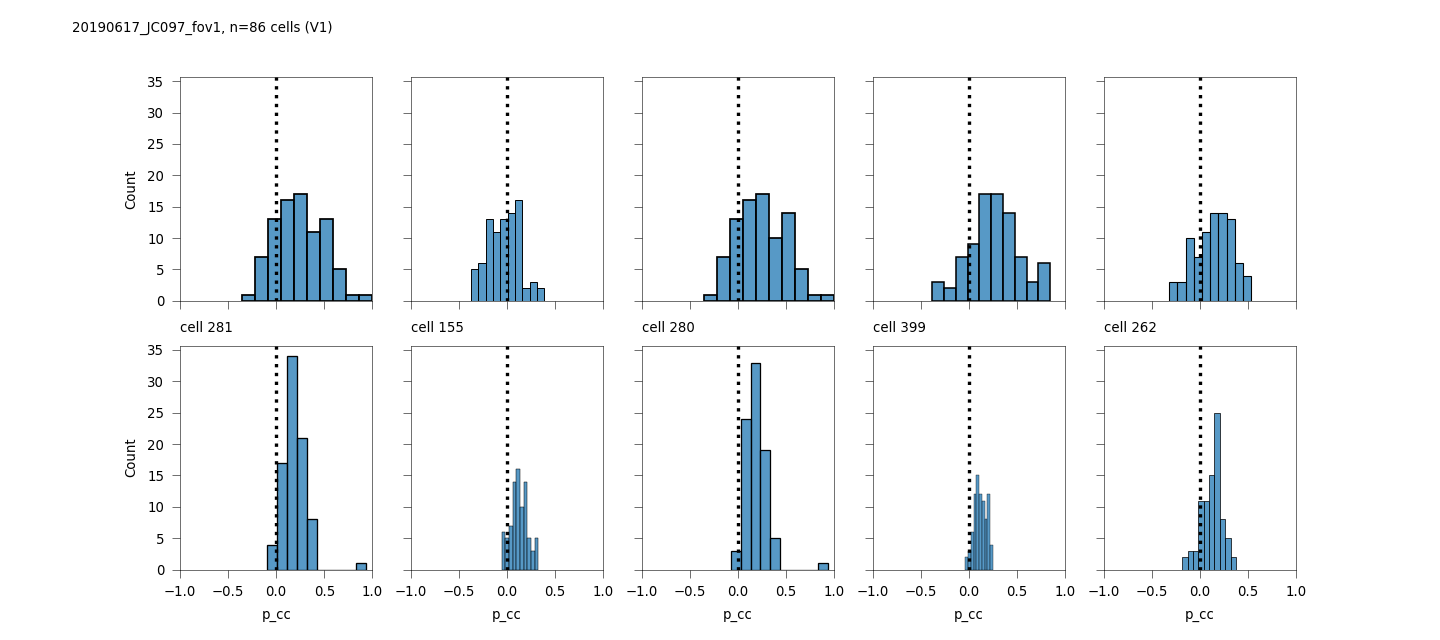

Text(0.05, 0.95, '20190617_JC097_fov1, n=86 cells (V1)')

In [204]:
rid=155
fig, axn = pl.subplots(2, 5, figsize=(9,4), sharex=True, sharey=True)

for ai, ri, in enumerate(top5):
    ax=axn[0, ai]
    currd = signal_corrs[
                (signal_corrs['cell_1']==ri) | (signal_corrs['cell_2']==ri)].copy()
    sns.histplot(x='p_cc', data=currd, ax=ax, bins=10)
    ax=axn[1, ai]
    currd = noise_corrs[
                (noise_corrs['cell_1']==ri) | (noise_corrs['cell_2']==ri)].copy()
    sns.histplot(x='p_cc', data=currd, ax=ax, bins=10)
    ax.set_title('cell %i' % ri, loc='left', fontsize=6)
    
for ax in axn.flat:
    ax.set_xlim([-1, 1])
    ax.axvline(x=0, color='k', ls=':')
    
fig.text(0.05, 0.95, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

#### Scatter plot comparing Signal/Noise per cell

In [205]:
corrs1 = signal_corrs.copy().rename(
                            columns={'p_cc': 'signal_cc', 'p_value': 'signal_p'})
corrs2 = noise_corrs.copy().rename(
                            columns={'p_cc': 'noise_cc', 'p_value': 'noise_p'})
corrs2.index = corrs2['neuron_pair'].values
print(corrs1.shape, corrs2.shape)
corrs = pd.merge(corrs1, corrs2)


(3655, 5) (3655, 5)


In [206]:
nplot=20
top_ = currfits.sort_values(by=sorter, ascending=False)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:nplot]['cell'].values

In [207]:
currfits.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,sf,size,speed,visual_area,datakey,animalid,fov,session,tf,tested_theta
2775,0.195308,0.571425,0.020930,-0.021574,0.090963,74.579649,191.020408,0.853096,1.0,0.760906,...,0.1,200.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,2.0,180.0
2782,0.496438,0.252988,0.082878,-0.039848,0.102565,54.962971,88.163265,0.796958,22.0,0.710106,...,0.5,20.0,10.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,5.0,90.0
2788,0.736206,0.119156,0.041650,0.007465,0.052532,22.501239,264.489796,0.897492,37.0,0.825375,...,0.1,200.0,10.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,1.0,270.0
2799,0.552736,0.607409,0.030281,-0.001267,0.081455,37.089249,279.183673,0.788202,52.0,0.698670,...,0.1,20.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,2.0,270.0
2804,0.213157,0.491717,0.019220,-0.023134,0.056257,86.467439,315.918367,0.774580,60.0,0.719698,...,0.5,20.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,10.0,315.0


In [219]:
def equal_corr_axes(fg):

    for ax in fg.axes:
        ax.set_aspect('equal')
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        #ax.legend_.remove()
        ax.plot([-1, 1], [-1, 1], color='r', ls='-', lw=0.5)


In [220]:
sorted_={}
nplot=10
for d, g in currfits.groupby(['tested_theta']):
    sorted_[d] = g.sort_values(by=sorter, ascending=False)\
                                .iloc[0:nplot]['cell'].values
sorted_

{45.0: array([100.]),
 90.0: array([280., 399., 361., 229., 125., 211.,  66.,  22.]),
 135.0: array([155., 146., 119.]),
 180.0: array([203.,   1., 291.,  91.]),
 225.0: array([262., 123., 200.,  69., 377., 111.,  65.]),
 270.0: array([281., 311.,  37., 215., 104., 216.,  52., 224., 107.]),
 315.0: array([183.,  60.])}

<IPython.core.display.Javascript object>


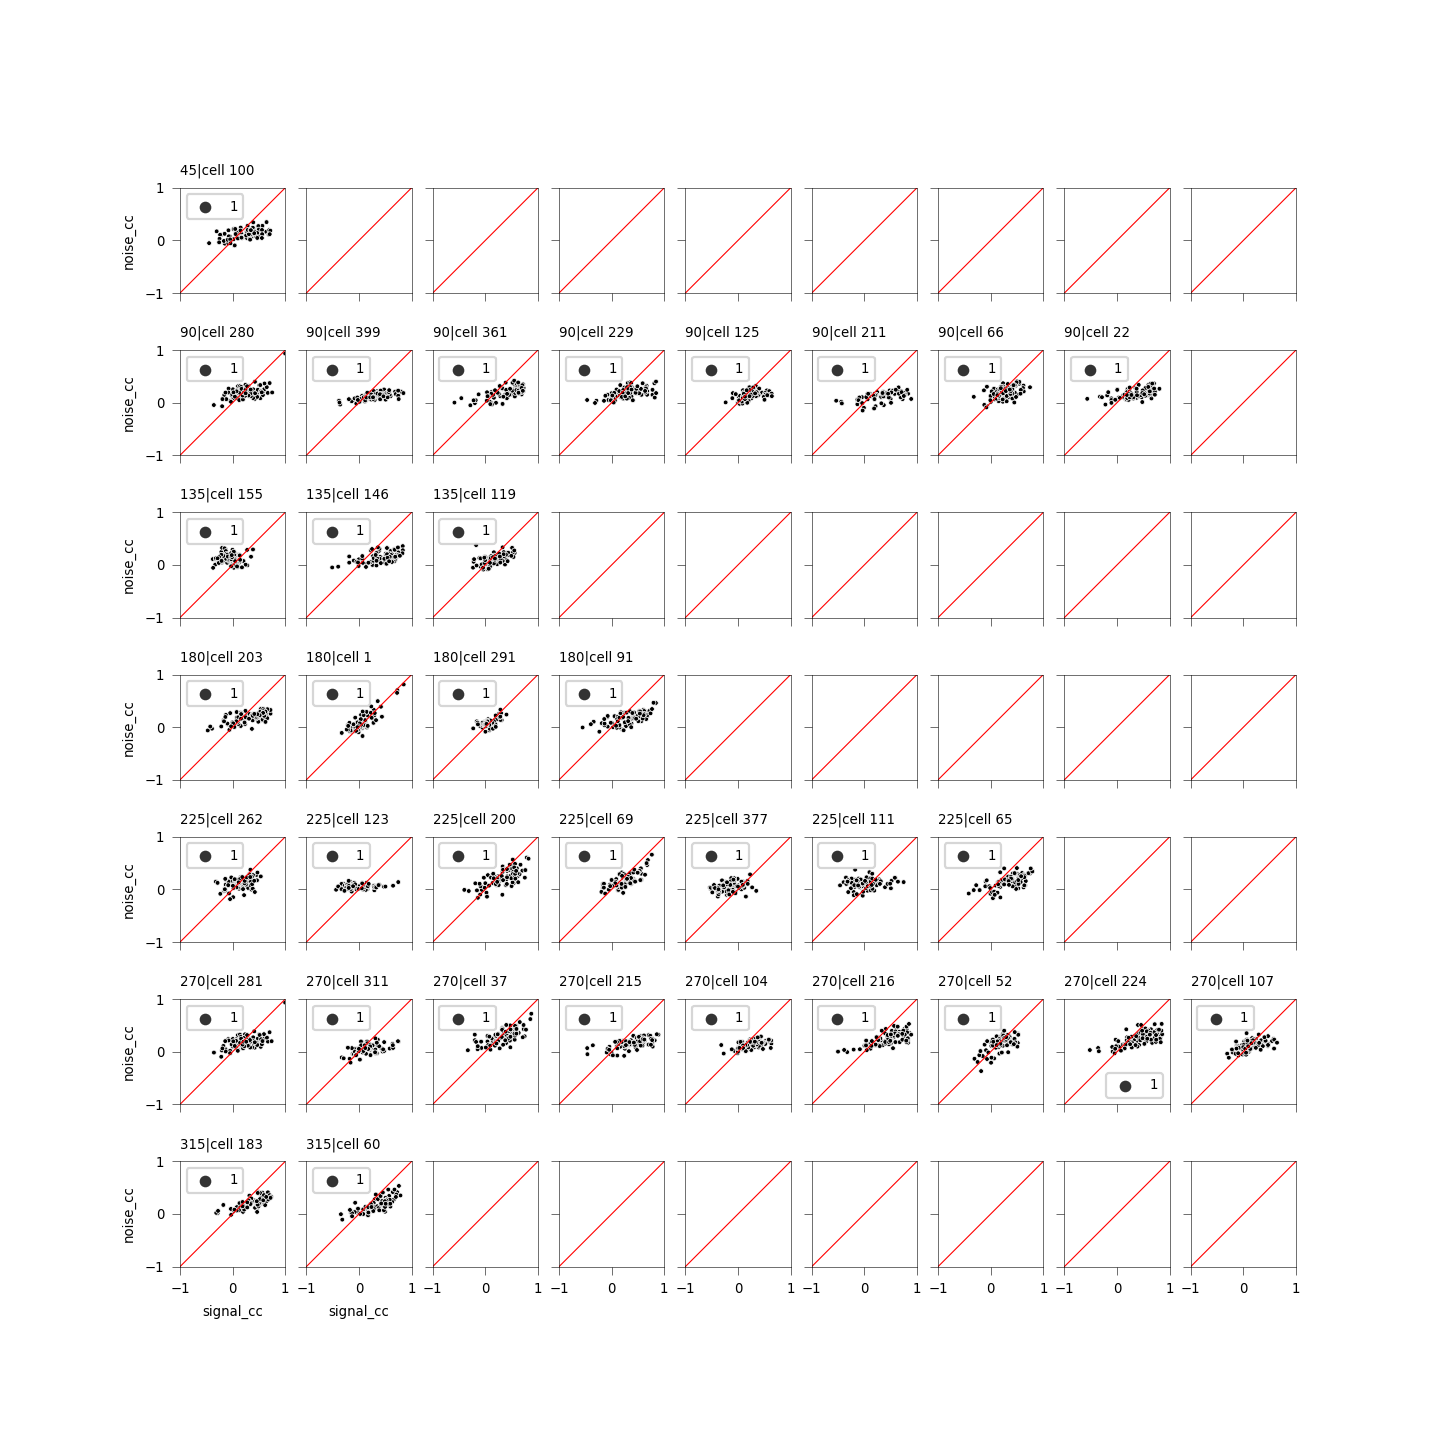

In [221]:

ncol=max([len(v) for k, v in sorted_.items()])

fig, axn = pl.subplots(len(sorted_), ncol, figsize=(9,9), sharex=True, sharey=True)
for ai, (k, v) in enumerate(sorted_.items()):
    for ci, ri in enumerate(v):
        ax=axn[ai, ci]
        currd = corrs[(corrs['cell_1']==ri) | (corrs['cell_2']==ri)].copy()
        sns.scatterplot(x='signal_cc', y='noise_cc', data=currd, ax=ax,
                   size=1, color='k', marker='.')
        ax.set_title('%i | cell %i' % (k, ri), loc='left', fontsize=6)
        ax.legend_.remove()
equal_corr_axes(fig)

fig.text(0.05, 0.95, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

In [127]:
len(currd)

85

In [39]:
%matplotlib notebook

In [ ]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = p3.add_rf_positions(posdf)

In [ ]:
selective_only=False
stimulus_type='allstim'

assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

if stimulus_type=='fullscreen':
    SD = fullSDF.copy()
elif stimulus_type=='apertured':
    SD = apSDF.copy()
else:
    SD = SDF.copy()
    
roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
print(roi_filter)

#### Test 1 animal

In [81]:
va='V1'
#dk='20190522_JC084_fov1'
dk = '20190617_JC097_fov1'
ori_dir = gutils.get_ori_dir(dk, traceid=traceid, fit_desc=ori_fit_desc)
print(ori_dir)
# Loads tuning results (bootstrapped)
fitresults, fitparams = gutils.load_tuning_results(dk, 
                                fit_desc=ori_fit_desc, traceid=traceid)
g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)
# Get fits
best_fits, all_fits = gutils.get_good_fits(boot_, fitparams, 
                                                 gof_thr=None, verbose=False)

/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e3c1f2_traces001_467d9f_traces001_88209d_traces001_359554/tuning/fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


In [82]:
rid=155
fitresults[rid].keys()
cfg_values = [tuple(c) for c in fitparams['non_ori_configs']]

In [83]:
n_intervals_interp = 3
stimparam = cfg_values[0]
bootr = boot_[rid][stimparam]
thetas_interp = bootr['fits']['xv']
thetas = bootr['fits']['xv'][0::n_intervals_interp]

In [84]:
r2comb, gof, fitr = gutils.evaluate_fits(bootr, interp=True)
origr0 = bootr['data']['responses'].mean(axis=0).values
#origr = np.abs(origr0 - origr0.mean())
origr = (origr0 - origr0.min()) #- (origr0 - origr0.mean()).min()
origr = np.append(origr, origr[0]) # wrap back around
print(len(origr), len(fitr)) 

9 25


In [275]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)


old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
NDATA = p3.split_datakey(NDATA)
NDATA = NDATA[~NDATA.animalid.isin(old_rats)]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [277]:
NDATA[NDATA.visual_area=='Li']['datakey'].unique()

array(['20190522_JC089_fov1', '20190527_JC092_fov3',
       '20190602_JC091_fov1', '20190606_JC091_fov1',
       '20190607_JC091_fov1', '20190609_JC099_fov1',
       '20190612_JC099_fov1', '20190614_JC091_fov1',
       '20190617_JC099_fov1', '20191018_JC113_fov1',
       '20191105_JC117_fov1', '20191111_JC120_fov1'], dtype=object)

In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


In [283]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [284]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = p3.add_rf_positions(posdf)

Adding RF position info...


In [285]:
posdf.shape, posdf.dropna().shape

((1675, 13), (1675, 13))

In [323]:
selective_only=False
stimulus_type='allstim'

assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

if stimulus_type=='fullscreen':
    SD = fullSDF.copy()
elif stimulus_type=='apertured':
    SD = apSDF.copy()
else:
    SD = SDF.copy()
    
roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
print(roi_filter)

allcells


In [324]:
c_ = []
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    rois_ = ndf['cell'].unique()
    if len(rois_)<2:
        continue
    if dk not in SD.keys():
        continue
    sdf = SD[dk].copy()
    cfgs = sdf.index.tolist()
    if len(cfgs)==0:
        continue
    ndf = ndf[(ndf.config.isin(cfgs))]
    # Reshape dataframe to ntrials x nrois
    trial_means0 = p3.stacked_neuraldf_to_unstacked(ndf)
    # Zscore trials
    cfgs_by_trial = trial_means0['config']
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) & (passg.datakey==dk)]['cell'].unique()
        if len(curr_cells)<5:
            continue
    else:
        curr_cells = rois_
    trial_means = trial_means0[curr_cells].copy()
    zscored = p3.zscore_dataframe(trial_means)
    zscored['config'] = cfgs_by_trial
    # Get mean reposnse per condition
    tuning_ = zscored.groupby(['config']).mean().reset_index()
    sigcorrs = calculate_signal_correlations(tuning_)
    # Get current FOV rfdata and add position info to sigcorrs df
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[sigcorrs['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[sigcorrs['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    sigcorrs['cortical_distance'] = dists
    sigcorrs['visual_area'] = va
    sigcorrs['datakey'] = dk
    c_.append(sigcorrs)
signal_corrs = pd.concat(c_, axis=0).reset_index(drop=True)


In [325]:
# Bin cortical distances for plotting
n_bins_dist = 10
n_bins_overlap = 8
use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    signal_corrs['binned_dist'], bin_edges = pd.qcut(signal_corrs['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    signal_corrs['binned_dist'], bin_edges = pd.cut(signal_corrs['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False

binning: eqwidth10


In [326]:
min_n_pairs=10
counts_per_bin = signal_corrs.groupby(['visual_area', 'datakey', 'binned_dist'])\
                    ['PCC'].count().reset_index()
pass_keys = [(va, dk) for (va, dk), g in \
             counts_per_bin[counts_per_bin['PCC']>=min_n_pairs].groupby(['visual_area', 'datakey'])]
CC = pd.concat([g for (va, dk), g in signal_corrs.groupby(['visual_area', 'datakey']) \
               if (va, dk) in pass_keys])
CC.shape, signal_corrs.shape

((90940, 8), (90995, 8))

In [327]:
mean_ccs = CC.groupby(['visual_area', 'datakey', 'binned_dist']).mean().reset_index()

<IPython.core.display.Javascript object>


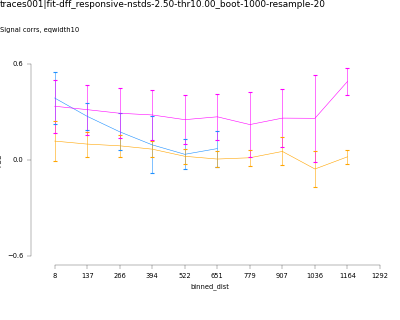

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics sigcorrs_by_dist__allstim_allcells


In [329]:
lw=0.5
metric='PCC'
fig, ax = pl.subplots( figsize=(5,4)) #, sharex=True, sharey=False)
sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, 
             ci='sd', err_style='bars', 
            err_kws={'capsize':2, 'lw': lw}, lw=lw)
ax.set_xticks(list(range(len(bin_edges))))
ax.set_xticklabels([round(i) for i in bin_edges])
ax.set_ylim([-0.6, 0.6])
ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])

sns.despine(offset=8, trim=True, ax=ax)
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal corrs, %s' % bin_type)
figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## ASI/DSI

In [31]:
def combine_metrics(scatdf):
    all_cols = [k for k in scatdf.columns if k!='asi']
    sd1 = scatdf[all_cols].copy().rename(columns={'dsi': 'value'})
    sd1['ori_metric'] = 'dsi'

    all_cols = [k for k in scatdf.columns if k!='dsi']
    sd2 = scatdf[all_cols].copy().rename(columns={'asi': 'value'})
    sd2['ori_metric'] = 'asi'

    sd = pd.concat([sd1, sd2], axis=0)
    return sd

In [331]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()
combog = combine_metrics(passg)


<IPython.core.display.Javascript object>


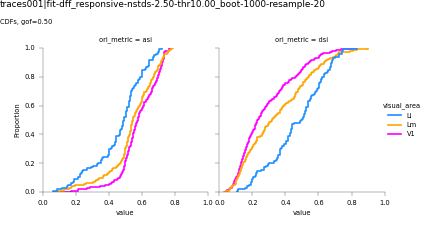

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics 0.5


In [332]:
fg = sns.displot(combog, col='ori_metric', col_order=['asi', 'dsi'],
            x='value', hue='visual_area', palette=area_colors, height=3,
           kind='ecdf', aspect=0.8)
for ax in fg.axes.flat:
    ax.set_xlim([0, 1])
fg.fig.text(0.0, 0.9, 'CDFs, gof=%.2f' % gof_thr)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'ASI_DSI_gof%.2f_cdf' % gof_thr
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, gof_thr)

In [333]:
gof_thr

0.5

In [338]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()

In [348]:
combog = combine_metrics(passg)
curr_counts = combog.groupby(['visual_area', 'datakey']).count().reset_index()
curr_counts = p3.split_datakey(curr_counts)
unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
finaldf = pd.concat([g for (va, dk), g in combog.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

<IPython.core.display.Javascript object>


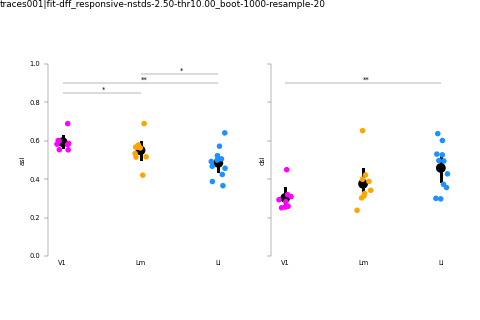

********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.030301   16.0   8   9
1  V1  Li    True  0.006584    9.0   8  11
2  Lm  Li    True  0.030301   24.0   9  11
****************************
********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.069145   18.0   8   9
1  V1  Li    True  0.006584    9.0   8  11
2  Lm  Li   False  0.085730   31.0   9  11
****************************


In [349]:
meang = finaldf.groupby(['visual_area', 'datakey', 'ori_metric']).mean().reset_index()
# fg = sns.FacetGrid(meang, col='ori_metric', col_order=['asi', 'dsi'], 
#               height=3)

# fg.map(sns.stripplot,'visual_area', 'value', 'visual_area', 
#        palette=area_colors)
# fg.map(sns.pointplot,'visual_area', 'value', join=False, color='k')

multi_comp_test='fdr_bh'
fig, axn = pl.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)
for ax, (metric, mg) in zip(axn.flat, meang.groupby(['ori_metric'])):
    sns.stripplot(x='visual_area', y='value', data=mg, ax=ax,
                 palette=area_colors, hue='visual_area', order=visual_areas)
    sns.pointplot(x='visual_area', y='value', data=mg, ax=ax,
                  order=visual_areas, color='k', join=False)
    pplot.plot_mannwhitney(mg, metric='value', ax=ax, 
                        multi_comp_test=multi_comp_test,
                        y_loc=0.85, offset=0.05, lw=0.25,fontsize=6)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    sns.despine(bottom=True, ax=ax)
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

# fig.text(0, 0.9, 'ASI & DSI, Means by FOV (gof=%.2f, mc=%s)' % (gof_thr, multi_comp_test))
# figname = 'ASI_DSI_gof%.2f_byFOV' % gof_thr
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, gof_thr)

## Counts

In [354]:
gdata[gdata.visual_area=='Li']

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,gof,sf,size,speed,visual_area,datakey,animalid,fov,session
0,0.528705,0.524802,0.025275,-0.010931,0.038352,52.129545,0.000000,0.727584,160.0,0.365496,0.376922,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
1,0.341041,0.685649,0.020652,-0.017558,0.059309,53.811532,132.244898,0.793545,170.0,0.323455,0.397306,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
2,0.590751,0.679958,0.009313,-0.001160,0.027233,39.562740,352.653061,0.892822,172.0,0.899031,0.765403,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
3,0.241354,0.572965,0.024139,-0.021777,0.047835,69.826945,227.755102,0.671892,177.0,0.660583,0.458513,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
4,0.407956,0.362389,0.017694,-0.012919,0.037090,70.338493,80.816327,0.603767,178.0,0.327887,0.230345,0.1,60.0,10.0,Li,20190314_JC070_fov1,JC070,FOV1_zoom2p0x,20190314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,0.527400,0.642588,0.012131,-0.000475,0.025826,49.363570,337.959184,0.545497,20.0,0.179227,0.160924,0.5,200.0,20.0,Li,20191105_JC117_fov1,JC117,FOV1_zoom2p0x,20191105
487,0.607651,0.489988,0.009905,0.001922,0.022655,35.299134,308.571429,0.566529,20.0,0.209501,0.201317,0.1,200.0,20.0,Li,20191105_JC117_fov1,JC117,FOV1_zoom2p0x,20191105
488,0.543529,0.612775,0.012180,-0.003092,0.033279,43.136791,132.244898,0.751625,20.0,0.462130,0.431036,0.1,200.0,10.0,Li,20191105_JC117_fov1,JC117,FOV1_zoom2p0x,20191105
489,0.513413,0.276885,0.110679,-0.047936,0.146132,48.301936,286.530612,0.819210,13.0,0.733408,0.587329,0.1,40.0,20.0,Li,20191111_JC120_fov1,JC120,FOV1_zoom2p0x,20191111


In [355]:
responsive_ = gdata.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
responsive_.shape

(34, 3)

In [356]:
tuned_ = bestg.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
tuned_.shape

(34, 3)

In [359]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()

pass_ = passg.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
pass_.shape

(33, 3)

In [360]:
# d_=[]
# for selector, t in zip(['visual', 'fit', 'gof'], [responsive_, tuned_, pass_]):
#     x = t.copy().rename(columns={'cell': selector}).reset_index(drop=True)
#     d_.append(x)
    
responsive0 = responsive_.copy()\
                .rename(columns={'cell': 'visual'}).reset_index(drop=True)

pass0 = pass_.copy()\
                .rename(columns={'cell': 'gof'}).reset_index(drop=True)
responsive0.head()

,visual_area,datakey,visual
0,Li,20190314_JC070_fov1,31
1,Li,20190315_JC070_fov2,6
2,Li,20190319_JC067_fov1,8
3,Li,20190522_JC089_fov1,15
4,Li,20190527_JC092_fov3,7


In [361]:
pass0[(pass0.visual_area==va) & (pass0.datakey==dk)]

,visual_area,datakey,gof
32,V1,20191006_JC110_fov1,21


In [364]:
counts = responsive0.copy()
for (va, dk), g in counts.groupby(['visual_area', 'datakey']):
    pg = pass0[(pass0.visual_area==va) & (pass0.datakey==dk)].copy()
    if len(pg)==0:
        ncells = 0
    else:
        ncells = float(pg['gof'])
    counts.loc[g.index, 'gof'] = ncells
# counts['gof'] = pass0['gof'].values
counts['gof_over_visual'] = counts['gof']/counts['visual'].astype(float)


In [365]:
# counts = pd.merge(responsive0, pass0, left_index=True, right_index=True, how='left')
# print(counts.shape)
# counts.head()

In [366]:
import copy

In [367]:
min_ncells=10

In [369]:
excl = copy.copy(old_rats) #['20190314_JC070_fov1', '20190306_JC061_fov2', '20190314_JC070_fov2']
currd =counts[(counts['visual']>=min_ncells) & ~(counts.datakey.isin(excl))].copy()
currd[currd.visual_area=='Lm']

,visual_area,datakey,visual,gof,gof_over_visual
15,Lm,20190306_JC061_fov2,66,31.0,0.469697
16,Lm,20190314_JC070_fov2,48,13.0,0.270833
17,Lm,20190512_JC083_fov1,166,10.0,0.060241
18,Lm,20190513_JC078_fov1,531,121.0,0.227872
19,Lm,20190517_JC083_fov1,20,5.0,0.250000
20,Lm,20190525_JC084_fov1,121,33.0,0.272727
21,Lm,20190603_JC080_fov1,171,44.0,0.257310
22,Lm,20190618_JC097_fov1,62,14.0,0.225806
23,Lm,20190627_JC091_fov1,77,20.0,0.259740


In [370]:
currd

,visual_area,datakey,visual,gof,gof_over_visual
0,Li,20190314_JC070_fov1,31,16.0,0.516129
3,Li,20190522_JC089_fov1,15,5.0,0.333333
5,Li,20190602_JC091_fov1,138,20.0,0.144928
6,Li,20190606_JC091_fov1,29,6.0,0.206897
7,Li,20190607_JC091_fov1,67,12.0,0.179104
8,Li,20190609_JC099_fov1,14,4.0,0.285714
9,Li,20190612_JC099_fov1,42,5.0,0.119048
10,Li,20190614_JC091_fov1,79,12.0,0.151899
11,Li,20190617_JC099_fov1,11,3.0,0.272727
12,Li,20191018_JC113_fov1,36,6.0,0.166667


<IPython.core.display.Javascript object>


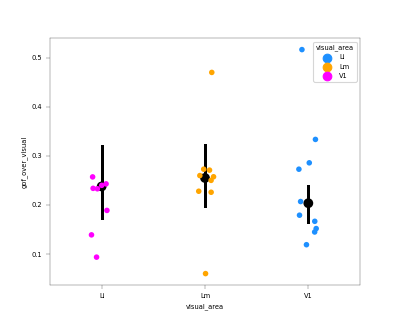

********* [gof_over_visual] Mann-Whitney U test(mc=holm) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.168527   19.0   8   9
1  V1  Li   False  0.624054   36.0   8  10
2  Lm  Li   False  0.624054   38.5   9  10
****************************


(   d1  d2  reject     p_val  U_val  n1  n2
 0  V1  Lm   False  0.168527   19.0   8   9
 1  V1  Li   False  0.624054   36.0   8  10
 2  Lm  Li   False  0.624054   38.5   9  10,
 <AxesSubplot:xlabel='visual_area', ylabel='gof_over_visual'>)

In [371]:

fig, ax = pl.subplots()
#sns.barplot(x='visual_area', y='fraction_gof_over_visual', data=currd, ax=ax)
sns.stripplot(x='visual_area', y='gof_over_visual', data=currd, ax=ax,
             order=visual_areas, hue='visual_area', palette=area_colors)
sns.pointplot(x='visual_area', y='gof_over_visual', data=currd, ax=ax, 
              join=False,  color='k')
pplot.plot_mannwhitney(currd, metric='gof_over_visual', 
            multi_comp_test='holm',
    ax=ax,
    y_loc=0.95,
    offset=0.1,
    lw=0.25,
    fontsize=6)

# Compare with RFs

In [322]:
# Load RF data
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
# Get ROI positions
rfdata = p3.add_rf_positions(rfdata)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4
Adding RF position info...


In [323]:
combined_rfs = rfutils.average_rfs_select(rfdata)
df_ = []
for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey']):
    if va=='Lm':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs'])]
    elif va=='Li':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs10'])]
    else:
        d_ = g.copy()
    df_.append(d_)
rfdf = pd.concat(df_)


In [325]:
RFS=[]
GFS=[]
for (va, dk), gr_ in bestg.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf['visual_area']==va) & (rfdf['datakey']==dk)].copy()
    if len(rfs_)==0:
        continue
    rf_cells = rfs_['cell'].unique()
    gr_cells = gr_['cell'].unique()
    common_cells = np.intersect1d(rf_cells, gr_cells)
    print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
    
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
print(DF['theta'].min(), DF['theta'].max())
DF['theta_deg'] = np.rad2deg(DF['theta_Mm_c'])
print(DF['theta_deg'].min(), DF['theta_deg'].max())
DF.dropna().groupby(['visual_area']).count()

Li: 0 cells in common (20190522_JC089_fov1)
Li: 5 cells in common (20190527_JC092_fov3)
Li: 35 cells in common (20190602_JC091_fov1)
Li: 6 cells in common (20190606_JC091_fov1)
Li: 9 cells in common (20190607_JC091_fov1)
Li: 1 cells in common (20190609_JC099_fov1)
Li: 3 cells in common (20190612_JC099_fov1)
Li: 14 cells in common (20190614_JC091_fov1)
Li: 1 cells in common (20190617_JC099_fov1)
Li: 4 cells in common (20191018_JC113_fov1)
Li: 0 cells in common (20191105_JC117_fov1)
Li: 0 cells in common (20191111_JC120_fov1)
Lm: 25 cells in common (20190512_JC083_fov1)
Lm: 19 cells in common (20190513_JC078_fov1)
Lm: 4 cells in common (20190517_JC083_fov1)
Lm: 23 cells in common (20190525_JC084_fov1)
Lm: 27 cells in common (20190603_JC080_fov1)
Lm: 3 cells in common (20190618_JC097_fov1)
Lm: 5 cells in common (20190627_JC091_fov1)
V1: 41 cells in common (20190511_JC083_fov1)
V1: 5 cells in common (20190512_JC083_fov1)
V1: 1 cells in common (20190517_JC083_fov1)
V1: 80 cells in common (2

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
Lm,106,106,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
V1,290,290,290,290,290,290,290,290,290,290,...,290,290,290,290,290,290,290,290,290,290


In [326]:
#gd =gdata[~gdata['animalid'].isin(old_rats)].copy()
GFS[GFS['visual_area']=='V1'].shape, GFS[GFS['visual_area']=='V1'].dropna().shape

((290, 20), (290, 20))

In [327]:
DF[DF['visual_area']=='V1'].shape, DF[DF['visual_area']=='V1'].dropna().shape

((290, 49), (290, 49))

In [344]:
counts_by_fov = DF[DF['gof']>=0.25].dropna().groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov = p3.split_datakey(counts_by_fov)

In [345]:
overall_best = p3.select_best_fovs(counts_by_fov)
overall_best.groupby(['visual_area']).sum()
overall_dkeys = list(tuple(k) for k in overall_best[['visual_area', 'datakey']].values)

finaldf = pd.concat([g for (va,dk), g in DF.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in overall_dkeys])

In [346]:
finaldf.dropna().groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
Lm,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
V1,289,289,289,289,289,289,289,289,289,289,...,289,289,289,289,289,289,289,289,289,289


In [347]:
finaldf[finaldf['gof']>=0.].groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
Lm,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
V1,289,289,289,289,289,289,289,289,289,289,...,289,289,289,289,289,289,289,289,289,289


In [348]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

<IPython.core.display.Javascript object>


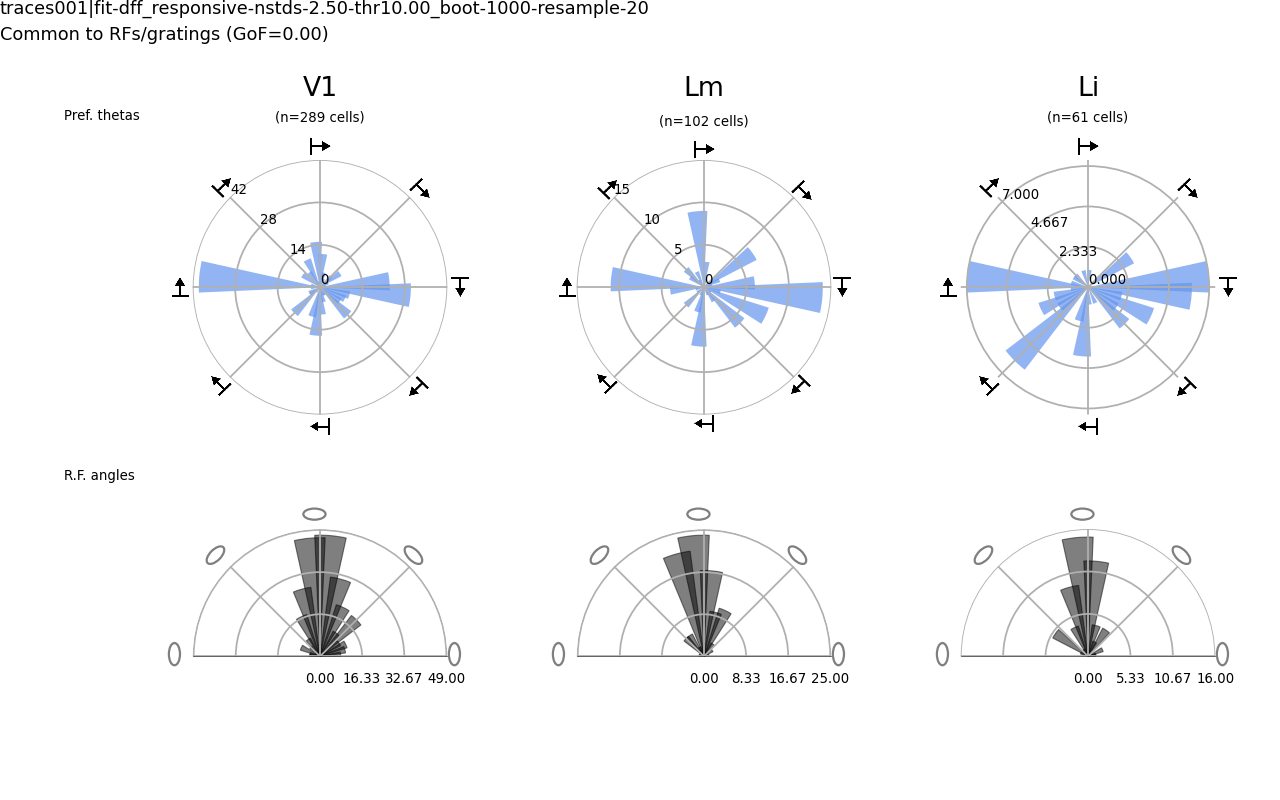

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics polar_theta_v_RFangles__gof0.00_drop_repeats


In [363]:
gof_thr=0.0

plotd = finaldf[finaldf['gof']>=gof_thr].copy().dropna()
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5
alpha=0.5

bar_width=15.
bin_size = 10

max_ori = 360.
ori_bins = np.arange(0, max_ori+bin_size, bin_size)
rf_bins = np.arange(-90, 90+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
ori_names = np.arange(0, max_ori+45, 45)

fig = pl.figure(figsize=(8,5))
i=0
for vi, visual_area in enumerate(visual_areas):
    g = plotd[plotd['visual_area']==visual_area].copy()
    # First, do PREFERRED THETA
    # --------------------------------------------------------------------
    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", 
               color=ori_color, linewidth=0.5)
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    pplot.replace_ori_labels(ori_names, ax=ax, 
                    xybox=(0, 0), yloc=ax.get_ylim()[-1]*1.1, zoom=0.12, polar=True)
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    # Now, do RECEPTIVE FIELD angles
    # ---------------------------------------------------------------------
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    i+=2
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8,
                   right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=6)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=6)
fig.text(0.0, 0.95, "Common to RFs/gratings (GoF=%.2f)" % gof_thr, 
             horizontalalignment='left', fontsize=8)

figname = 'polar_theta_v_RFangles__gof%.2f_%s' % (gof_thr, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [350]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins

In [351]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

In [352]:
DF.groupby(['visual_area']).count()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0,theta_deg
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
Lm,106,106,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
V1,290,290,290,290,290,290,290,290,290,290,...,290,290,290,290,290,290,290,290,290,290


<IPython.core.display.Javascript object>


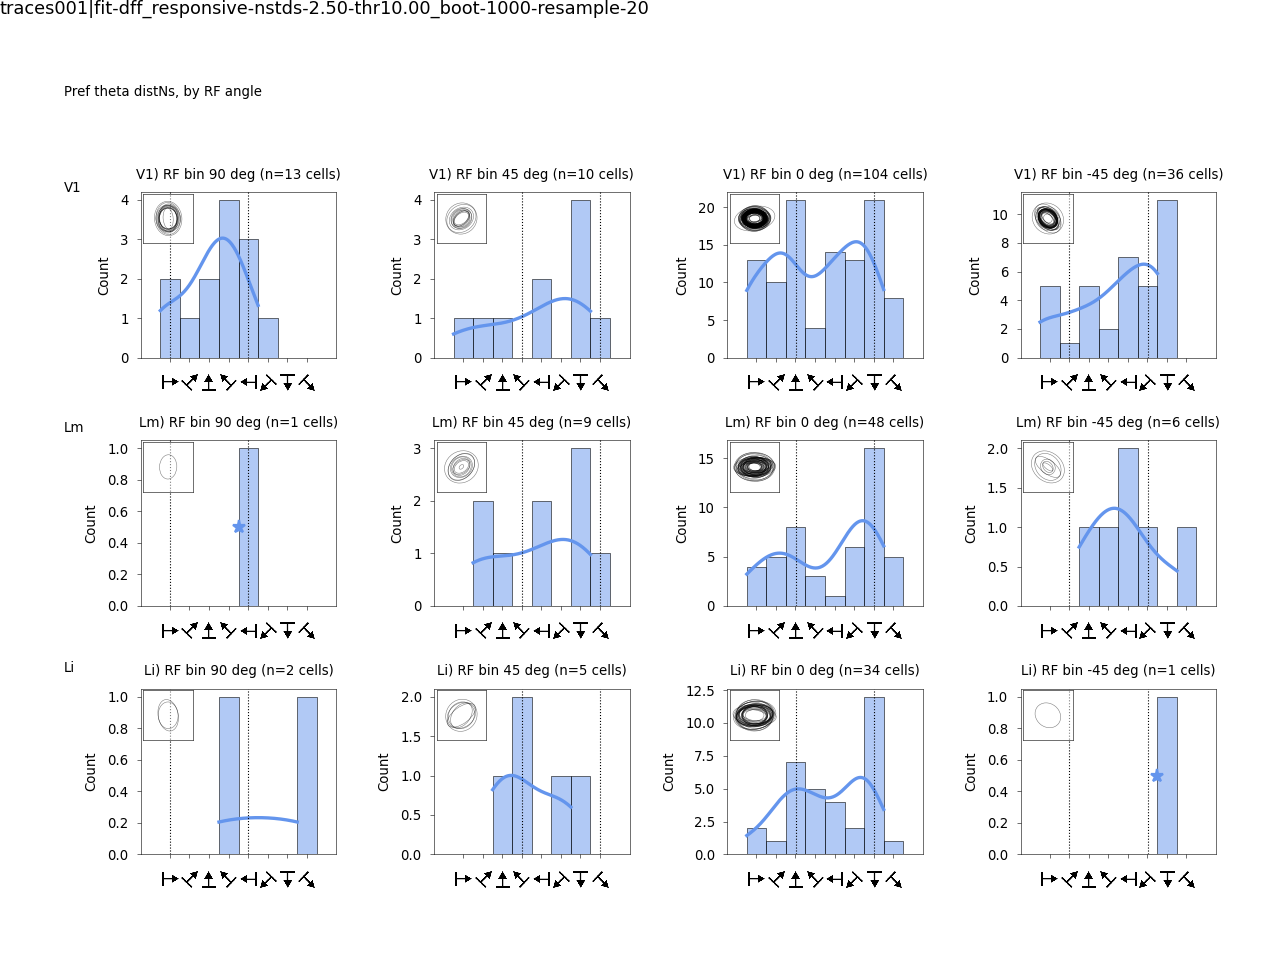

Li:: 78 cells


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Lm:: 106 cells
V1:: 290 cells
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics hist_RFangle_vs_preferredtheta_gof0.00_drop_repeats


In [364]:
rf_color='k'
ori_color='cornflowerblue'

plotd = DF.copy()
yloc=0.5
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5
rf_theta_param = 'theta_deg'
##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5
####
aniso_thr=0.1
filter_aniso=False
max_ori=360.
mod_val=360.
n_bins_dist = 8 if max_ori==360. else 4
ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)
label_unit='degrees'
# =====================================================
# PLOT
# =====================================================
fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(8,6),sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)
offset=0.25
for va, df_ in plotd.groupby(['visual_area']):
    vi = visual_areas.index(va) #vi, va in enumerate(visual_areas):
    #df_ = DF[(DF['visual_area']==va)].copy()
    print('%s:: %i cells' % (va, df_.shape[0]))
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['tested_theta'].values % mod_val
        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        ax.set_title("%s (%i, %i)" % (va, vi, ci))        
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, yloc, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.histplot(pref_theta_deg, ax=ax, bins=n_bins_dist, color=ori_color,
                    kde=True, stat='count', lw=.25, binrange=(0, 360))
#                     discrete=True) #$, ax=ax)
        #cnts, edges = np.histogram(pref_theta_deg, bins=8)
        #bwidth = np.mean(np.diff(edges))/2.
        #most_thetas = edges[cnts.argmax()] +bwidth
        #ax.plot(most_thetas, 0, color='r', marker='^')
        bwidth = np.mean(np.ediff1d(xticks))/2.
        line_loc = ((currbin+90)%360)+bwidth
        ax.axvline(x=line_loc, color='k', lw=0.5, ls=':')
        ax.axvline(x=(line_loc+180)%360., color='k', lw=0.5, ls=':')
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        pplot.replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)
        ax.tick_params(which='both', axis='both', labelsize=6, size=2)
        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = pplot.add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)
        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = mpl.patches.Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.25)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        pplot.turn_off_axis_ticks(ax1, despine=False)
        ax.set_title('%s) RF bin %i deg (n=%i cells)' % (va, currbin, ncells), fontsize=6)
        ax.set_xlim([-45, 360+45])
    fig.text(0.05, 0.8-(vi*offset), va)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
pplot.label_figure(fig, data_id)
    
figname = 'hist_RFangle_vs_preferredtheta_gof%.2f_%s' % (gof_thr, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

print(curr_dst_dir, figname)

In [574]:
curr_vs['tested_theta']

195    135.0
208    270.0
210    270.0
218    270.0
223    135.0
226     90.0
227     90.0
236      0.0
240    225.0
242    180.0
244     45.0
261    180.0
262     90.0
264      0.0
273    180.0
274    270.0
278    180.0
282     90.0
285    270.0
313    270.0
314    225.0
315    270.0
322    180.0
327    225.0
331    270.0
334    180.0
340    180.0
348     90.0
376    270.0
386    270.0
393      0.0
399      0.0
401      0.0
415    225.0
429    270.0
466    225.0
Name: tested_theta, dtype: float64

In [535]:
cnts, edges = np.histogram(pref_theta_deg, bins=20)
edges[cnts.argmax()+1]

array([ 3,  1,  0,  0,  3,  2,  0,  1,  1,  1,  4,  3,  2,  2,  1, 10,  0,
        0,  0,  2])

In [536]:
edges[cnts.argmax()+1]

276.2448979591837

# NON ORI PARAM

In [183]:
def index_from_samples(sampled_t, sdf=None, paramnames=['sf', 'size', 'speed']):
    '''
    For resampled df (rows=trials, cols=configs), calculate preference index
    for each parameter (sf, size, speed), where 1=prefers bigger, -1=prefers smaller.
    '''
    tt = sampled_t.T
    for p in paramnames:
        tt[p] = sdf.loc[tt.index][p]
    # Calculate index
    trial_cols = [t for t in tt.columns if t not in paramnames]
    p_ixs={}
    for p in paramnames:
        lo, hi = tt[p].unique().min(), tt[p].unique().max()
        v1 = tt[tt[p]==lo][trial_cols].mean().mean()
        v2 = tt[tt[p]==hi][trial_cols].mean().mean()
        ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
        p_ixs.update({p: ix})
    return pd.Series(p_ixs)

def get_trial_df(rd):
    '''
    From stacked neuraldf (1 roi's responses), return NtrialxNconfigs df.
    Add offset for calculating index.
    '''
    # Single value per trial, columns=configs, rows=trial
    trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
                              for c, g in rd.groupby(['config'])], axis=1)
    # Subtract min response (nonneg)
    vmin = trial_vals.min().min()
    if vmin < 0:
        trial_vals = trial_vals - vmin
    return trial_vals

def bootstrap_index_calculation(rd, sdf=None, n_bootstrap_iters=100,
                               paramnames=['sf', 'size', 'speed']):
    '''Resample trials (w replacement), then calculate preference metric '''
    # Single value per trial, columns=configs, rows=trial
    trial_vals = get_trial_df(rd)
    # Resample and calculate index on each (return Niters x 3)
    n_resamples=trial_vals.shape[0]
    iterd = pd.concat([index_from_samples(trial_vals.sample(n_resamples, replace=True), 
                        sdf=sdf, paramnames=paramnames) \
                       for _ in range(n_bootstrap_iters)], axis=1).T
    return iterd

def check_null(iterd, paramnames=['sf', 'size', 'speed'], alpha=95):
    '''
    Given bootstrapped metrics for sf, size, speed, do 2-tailed test for rejecting null,
    i.e., greater or less than 0 or nah.
    '''
    reject_or_no={}
    sf_lo, sz_lo, sp_lo = np.percentile(iterd, (100-alpha)/2, axis=0)
    sf_hi, sz_hi, sp_hi = np.percentile(iterd, alpha+((100-alpha)/2), axis=0)
    paramcis = [(sf_lo, sf_hi), (sz_lo, sz_hi), (sp_lo, sp_hi)]
    for par, ci_ in zip(paramnames, paramcis):
        reject_null = ~(ci_[0] < 0 < ci_[1])
        reject_or_no.update({par: reject_null})
    return pd.Series(reject_or_no)

def bootstrap_and_evaluate_nonori(rd, sdf=None, n_bootstrap_iters=100, alpha=95):
    '''
    Use with groupby.apply() for all cells. Does bootstrap analysis for non-ori
    metrics, then checks for H0 reject or nah
    '''
    iterd = bootstrap_index_calculation(rd, sdf=sdf, 
                            n_bootstrap_iters=n_bootstrap_iters)
    reject_ = check_null(iterd, alpha=alpha)
    #reject_['cell'] = float(rd['cell'].unique())
    return reject_



In [9]:
# def bootstrap_nonori(rd, n_bootstrap_iters=1000):
#     # Single value per trial, columns=configs, rows=trial
#     trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
#                               for c, g in rd.groupby(['config'])], axis=1)
#     # Resample (Nconfigs x Niters)
#     n_resamples=trial_vals.shape[0]
#     bootdf = pd.concat([trial_vals.sample(n_resamples, replace=True)\
#                         .mean(axis=0) for ni in range(n_bootstrap_iters)], axis=1)
#     d_=[]
#     for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#         iter_vals = bootdf.loc[g['config'].unique()].mean(axis=0) # avg across oris
#         df_ = pd.DataFrame(iter_vals, columns=['response'])
#         df_['size'] = sz
#         df_['sf'] = sf
#         df_['speed'] = sp
#         d_.append(df_)
#     iters = pd.concat(d_, axis=0)
#     return iters

# def is_reliable_or_no(rd, iters):
#     reliable_=[]
#     for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#         iter_vs = iters[(iters['size']==sz) & (iters['sf']==sf) & (iters['speed']==sp)]
#         ordered = sorted(iter_vs['response'])
#         ci_lower = np.percentile(ordered, (100-alpha)/2)
#         ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))
#         true_v =float(g['response'].mean())
#         r_val = ci_lower>0 and (ci_lower<true_v<ci_upper)
#         reliable_.append(r_val)
#     return any(reliable_)

# def test_reliable(rd):
#     iters = bootstrap_nonori(rd)
#     is_r = is_reliable_or_no(rd, iters)
#     return is_r

In [184]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=responsive_thr)
old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
NDATA = p3.split_datakey(NDATA)
NDATA = NDATA[~NDATA.animalid.isin(old_rats)]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [189]:
paramnames = ['size', 'speed', 'sf']
n_bootstrap_iters=100
outfile = os.path.join(curr_dst_dir, 'nonori_params.pkl')
calculate_nonori=False
try:
    with open(outfile, 'rb') as f:
        NON = pkl.load(f)
except Exception as e:
    print("Unable to load saved NON-ori calculations\n%s" % outfile)
    calculate_nonori=True
    

In [190]:
if calculate_nonori:
    R_=[]
    for (va, dk), rdf in NDATA.groupby(['visual_area', 'datakey']):
        sdf = p3.get_stimuli(dk, 'gratings')
        for p in paramnames:
            rdf[p] = sdf.loc[rdf['config']][p].values
        R = rdf.groupby('cell').apply(bootstrap_and_evaluate_nonori, sdf=sdf, 
                                      n_bootstrap_iters=n_bootstrap_iters)
        pass_ = R[R.any(axis=1)]
        pass_['cell'] = pass_.index
        pass_['visual_area'] = va
        pass_['datakey'] = dk
        #reliable_rois = rdf.groupby(['cell']).apply(test_reliable)
        #pass_ = reliable_rois[reliable_rois==True].index.tolist()
        print('%s %s (%i/%i)' % (va,dk, len(pass_), len(rdf['cell'].unique())))
        R_.append(pass_)
    NON = pd.concat(R_, axis=0)
    # save
    with open(outfile, 'wb') as f:
        pkl.dump(NON, f, protocol=2)

In [191]:
NON[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,225,225
Lm,497,497
V1,791,791


## Caculate preference index for cells that pass

In [192]:
def calculate_nonori_index(rd, param='sf'):
    vmin = rd['response'].min()
    if vmin < 0:
        rd['response'] = rd['response'] - vmin
    lo, hi = rd[param].unique().min(), rd[param].unique().max()
    v1 = rd[rd[param]==lo]['response'].mean() 
    v2 = rd[rd[param]==hi]['response'].mean() 
    ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
    return ix #pd.Series(ix) #, index=[rid])

def calculate_nonori_index_all(rd, paramnames=['size', 'speed', 'sf']):
    vmin = rd['response'].min()
    if vmin < 0:
        rd['response'] = rd['response'] - vmin
    p_ixs={}
    for p in paramnames:
        lo, hi = rd[p].unique().min(), rd[p].unique().max()
        v1 = rd[rd[p]==lo]['response'].mean() 
        v2 = rd[rd[p]==hi]['response'].mean() 
        ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
        p_ixs.update({p: ix})
    return pd.Series(p_ixs) #, index=[rid])

In [193]:
# def calculate_index_fov(rdf, paramnames=['sf', 'size', 'speed']):
#     x_=[]
#     for param in paramnames:
#         ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
#         ixs_ = pd.DataFrame(ixs0, columns=['value'])
#         ixs_['metric'] = param
#         ixs_['cell'] = ixs_.index
#         x_.append(ixs_.reset_index(drop=True))
#     curr_ixs = pd.concat(x_, axis=0).reset_index(drop=True)
#     return curr_ixs

def calculate_index_fov(rdf, sdf, param='sf'):
    rdf[param] = sdf.loc[rdf['config']][param].values
    # Get preference index for all cells in FOV that pass
    #ixs_ = calculate_index_fov(rdf, paramnames=paramnames)
    ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
    ixs_ = pd.DataFrame(ixs0, columns=['value'])
    ixs_['metric'] = param
    ixs_['cell'] = ixs_.index.tolist()
    return ixs_

In [194]:

def aggregate_nonori_index(NDATA, NON, param='sf'):
    i_=[]
    for (va, dk), g in NON.groupby(['visual_area', 'datakey']):
        pass_ = g[g[param]]['cell'].unique()
        rdf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)
                   & (NDATA['cell'].isin(pass_))].copy()
        # Assign stimulus info
        sdf = p3.get_stimuli(dk, 'gratings')
        # Get preference index for all cells in FOV that pass
        ixs_ = calculate_index_fov(rdf, sdf, param=param)
        #ixs_ = rdf.groupby(['cell']).apply(calculate_nonori_index)
        ixs_['visual_area'] = va
        ixs_['datakey'] = dk
        i_.append(ixs_)
    ixs = pd.concat(i_, axis=0)
    return ixs

In [195]:
p_=[]
for param in paramnames:
    param_ixs = aggregate_nonori_index(NDATA, NON, param=param)
    p_.append(param_ixs)
ixs = pd.concat(p_)

In [196]:
ixs.head()

,value,metric,cell,visual_area,datakey
cell,,,,,
108,0.0,size,108.0,Li,20190522_JC089_fov1
115,0.0,size,115.0,Li,20190522_JC089_fov1
117,0.0,size,117.0,Li,20190522_JC089_fov1
122,0.0,size,122.0,Li,20190522_JC089_fov1
128,0.0,size,128.0,Li,20190522_JC089_fov1


In [197]:
# Get unique datasets by N cells
curr_counts = ixs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
curr_counts = p3.split_datakey(curr_counts)
unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
nonori_df = pd.concat([g for (va, dk), g in \
                    ixs.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in final_dkeys])

In [198]:
nonori_df[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,153,153
Lm,486,486
V1,753,753


In [200]:
nonori_df.head()

,value,metric,cell,visual_area,datakey
cell,,,,,
108,0.0,size,108.0,Li,20190522_JC089_fov1
115,0.0,size,115.0,Li,20190522_JC089_fov1
117,0.0,size,117.0,Li,20190522_JC089_fov1
122,0.0,size,122.0,Li,20190522_JC089_fov1
128,0.0,size,128.0,Li,20190522_JC089_fov1


<IPython.core.display.Javascript object>


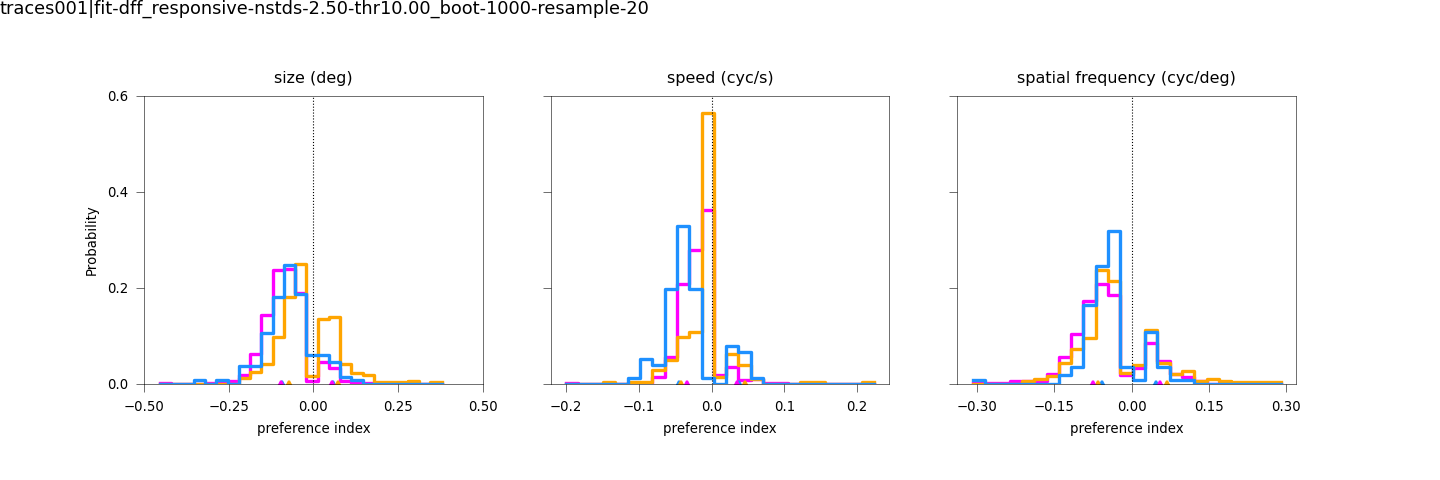

In [304]:
plot_type='stephist'
fig, axn = pl.subplots(1, len(paramnames), sharey=True, figsize=(9,3))
for ax, p in zip(axn.flat, paramnames):
    df_ = nonori_df[nonori_df['metric']==p].copy()
    sns.histplot(x='value', data=df_, 
                 hue='visual_area', palette=area_colors, ax=ax, bins=25,
                  stat='probability', common_norm=False, fill=False,
                element='step')#,
                 #multiple="stack")
    for va, vg in df_.groupby(['visual_area']):
        ax.plot(vg[vg['value']<0]['value'].mean(), -0.0, 
                marker='^', color=area_colors[va], markersize=3)
        ax.plot(vg[vg['value']>0]['value'].mean(), -0.0, marker='^', 
                color=area_colors[va], markersize=3)

    ax.axvline(x=0,color='k', lw=0.5, ls=':')
    ax.set_title(p)
    ax.legend_.remove()
    if p=='size':
        ax.set_title('size (deg)')
        ax.set_xticks(np.linspace(-0.5, 0.5, 5))
    elif p=='speed':
        ax.set_title('speed (cyc/s)')
        ax.set_xticks(np.linspace(-0.2, 0.2, 5))
    else:
        ax.set_title('spatial frequency (cyc/deg)')
        ax.set_xticks(np.linspace(-0.3, 0.3, 5))
    ax.set_ylim((0, 0.6))
    ax.set_yticks(np.linspace(0, 0.6, 4))
    ax.set_yticklabels([round(i, 1) for i in np.linspace(0, 0.6, 4)])
    ax.set_xlabel('preference index')
        
    #sns.despine(trim=True, offset=-2, left=False)
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8)
pplot.label_figure(fig, data_id)

figname = 'nonori_distns_%s_%s' % (plot_type, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [269]:
nonori_counts = nonori_df[['visual_area', 'datakey', 'cell', 'metric']].drop_duplicates()\
                    .groupby(['metric', 'visual_area', 'datakey']).count().reset_index()
nonori_counts.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in nonori_counts[['visual_area', 'datakey']].values]

In [271]:
nonori_counts[nonori_counts['metric']=='sf']

,metric,visual_area,datakey,cell
Li_20190522_JC089_fov1,sf,Li,20190522_JC089_fov1,4
Li_20190602_JC091_fov1,sf,Li,20190602_JC091_fov1,39
Li_20190612_JC099_fov1,sf,Li,20190612_JC099_fov1,17
Li_20190614_JC091_fov1,sf,Li,20190614_JC091_fov1,30
Li_20191018_JC113_fov1,sf,Li,20191018_JC113_fov1,20
Lm_20190512_JC083_fov1,sf,Lm,20190512_JC083_fov1,73
Lm_20190513_JC078_fov1,sf,Lm,20190513_JC078_fov1,83
Lm_20190525_JC084_fov1,sf,Lm,20190525_JC084_fov1,43
Lm_20190603_JC080_fov1,sf,Lm,20190603_JC080_fov1,62
Lm_20190618_JC097_fov1,sf,Lm,20190618_JC097_fov1,17


In [272]:
final_counts['sf_selective'] = nonori_counts[nonori_counts['metric']=='sf']['cell']

final_counts['size_selective'] = nonori_counts[nonori_counts['metric']=='size']['cell']

final_counts['speed_selective'] = nonori_counts[nonori_counts['metric']=='speed']['cell']

In [276]:
final_counts = final_counts.fillna(0)


In [279]:
for p in paramnames:
    final_counts['fraction_%s' % p] = final_counts['%s_selective' % p]/final_counts['visual']
    

In [ ]:
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

<IPython.core.display.Javascript object>


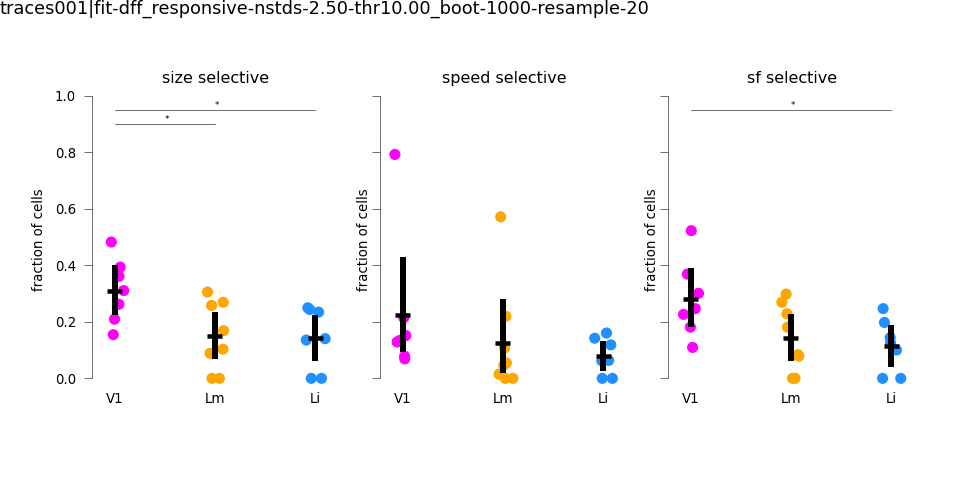

********* [fraction_size] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.024092    9.0   7   8
1  V1  Li    True  0.024092    6.0   7   7
2  Lm  Li   False  0.385167   25.0   8   7
****************************
********* [fraction_speed] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.088413   14.0   7   8
1  V1  Li   False  0.088413   11.0   7   7
2  Lm  Li   False  0.430476   26.0   8   7
****************************
********* [fraction_sf] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.054445   12.0   7   8
1  V1  Li    True  0.044493    7.0   7   7
2  Lm  Li   False  0.385167   25.0   8   7
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics fractioN_nonori_selective_drop_repeats


In [320]:
fig, axn = pl.subplots(1,len(paramnames), figsize=(6,3), sharey=True, sharex=True)
for ax, p in zip(axn.flat, paramnames):
    sns.stripplot(x='visual_area', y='fraction_%s' % p, data=final_counts, ax=ax,
        hue='visual_area', palette=area_colors, order=visual_areas ,zorder=-1)
    sns.pointplot(x='visual_area', y='fraction_%s' % p, data=final_counts, ax=ax,
        color='k', markers='_', scale=1, errwidht=0.5, order=visual_areas, 
                  join=False, zorder=10000)
    pplot.plot_mannwhitney(final_counts, metric='fraction_%s' % p, ax=ax,
                        multi_comp_test=multi_comp_test,
                        y_loc=0.9, offset=0.05, lw=0.25,fontsize=4)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title("%s selective" % p)
    ax.set_xlabel('')
    ax.set_ylim([-0.02, 1])
    ax.set_yticks(np.linspace(0, 1, 6))
    sns.despine(bottom=True, trim=True, offset=2)
    ax.set_ylabel("fraction of cells")
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8, right=0.95) 
pplot.label_figure(fig, data_id)

figname = 'fractioN_nonori_selective_%s' % (dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [287]:
final_counts

,visual_area,datakey,tuned,direction_selective,fraction_dsi,axis_selective,fraction_asi,visual,fraction_tuned,pass_gof,fraction_gof,animalid,fov,session,sf_selective,size_selective,speed_selective,fraction_size,fraction_speed,fraction_sf
Li_20190314_JC070_fov1,Li,20190314_JC070_fov1,31,15,0.483871,1.0,0.032258,137,0.226277,16,0.116788,JC070,FOV1_zoom2p0x,20190314,0.0,0.0,0.0,0.000000,0.000000,0.000000
Li_20190315_JC070_fov2,Li,20190315_JC070_fov2,6,5,0.833333,0.0,0.000000,102,0.058824,5,0.049020,JC070,FOV2_zoom2p0x,20190315,0.0,0.0,0.0,0.000000,0.000000,0.000000
Li_20190522_JC089_fov1,Li,20190522_JC089_fov1,7,4,0.571429,1.0,0.142857,32,0.218750,5,0.156250,JC089,FOV1_zoom2p0x,20190522,4.0,8.0,2.0,0.250000,0.062500,0.125000
Li_20190602_JC091_fov1,Li,20190602_JC091_fov1,59,20,0.338983,1.0,0.016949,197,0.299492,20,0.101523,JC091,FOV1_zoom2p0x,20190602,39.0,48.0,28.0,0.243655,0.142132,0.197970
Li_20190612_JC099_fov1,Li,20190612_JC099_fov1,15,5,0.333333,0.0,0.000000,118,0.127119,5,0.042373,JC099,FOV1_zoom2p0x,20190612,17.0,16.0,14.0,0.135593,0.118644,0.144068
Li_20190614_JC091_fov1,Li,20190614_JC091_fov1,39,10,0.256410,2.0,0.051282,299,0.130435,12,0.040134,JC091,FOV1_zoom2p0x,20190614,30.0,42.0,19.0,0.140468,0.063545,0.100334
Li_20191018_JC113_fov1,Li,20191018_JC113_fov1,20,5,0.250000,1.0,0.050000,81,0.246914,6,0.074074,JC113,FOV1_zoom2p0x,20191018,20.0,19.0,13.0,0.234568,0.160494,0.246914
Lm_20190306_JC061_fov2,Lm,20190306_JC061_fov2,66,24,0.363636,7.0,0.106061,219,0.301370,31,0.141553,JC061,FOV2_zoom2p0x,20190306,0.0,0.0,0.0,0.000000,0.000000,0.000000
Lm_20190314_JC070_fov2,Lm,20190314_JC070_fov2,48,9,0.187500,4.0,0.083333,301,0.159468,13,0.043189,JC070,FOV2_zoom2p0x,20190314,0.0,0.0,0.0,0.000000,0.000000,0.000000
Lm_20190512_JC083_fov1,Lm,20190512_JC083_fov1,107,10,0.093458,0.0,0.000000,271,0.394834,10,0.036900,JC083,FOV1_zoom2p0x,20190512,73.0,70.0,155.0,0.258303,0.571956,0.269373


#### Test nonori w/ single FOV

In [193]:
va='V1'
dk ='20190617_JC097_fov1'
# va='Li'
# dk ='20190602_JC091_fov1'
rdf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
sdf = p3.get_stimuli(dk, 'gratings')
# Add stimulus info
for p in paramnames:
    rdf[p] = sdf.loc[rdf['config']][p].values

In [129]:
# Do bootstrap
# R = rdf.groupby('cell').apply(bootstrap_and_evaluate_nonori, sdf=sdf)
# R.head()

,sf,size,speed,cell
cell,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,2.0
3,0.0,1.0,0.0,3.0
5,0.0,0.0,0.0,5.0


In [131]:
R.loc[rid]

sf         1.0
size       0.0
speed      1.0
cell     155.0
Name: 155, dtype: float64

In [232]:
# x_=[]
# for param in paramnames:
#     ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
#     ixs_ = pd.DataFrame(ixs0, columns=['value'])
#     ixs_['metric'] = param
#     ixs_['cell'] = ixs_.index
#     x_.append(ixs_.reset_index(drop=True))
# curr_ixs = pd.concat(x_, axis=0)


In [224]:
ixs_ = rdf.groupby(['cell']).apply(calculate_nonori_index, param='size')

In [228]:
rid=280
rd = rdf[rdf['cell']==rid].copy()

In [230]:
param='size'
vmin = rd['response'].min()
if vmin < 0:
    rd['response'] = rd['response'] - vmin
lo, hi = rd[param].unique().min(), rd[param].unique().max()
v1 = rd[rd[param]==lo]['response'].mean() 
v2 = rd[rd[param]==hi]['response'].mean() 
ix = (v2-v1)/(v1+v2) 
print(param, ix)

size -0.09436637992575322


In [177]:
rid = 280 #155
rd = rdf[rdf['cell']==rid].copy()
trial_vals = get_trial_df(rd)
true_ = index_from_samples(trial_vals, sdf=sdf)


In [178]:
iterd = bootstrap_index_calculation(rd, sdf=sdf, 
                        n_bootstrap_iters=n_bootstrap_iters)
reject_ = check_null(iterd, alpha=alpha)
reject_['cell'] = float(rd['cell'].unique())

alpha=95
sf_lo, sz_lo, sp_lo = np.percentile(iterd, (100-alpha)/2, axis=0)
sf_hi, sz_hi, sp_hi = np.percentile(iterd, alpha+((100-alpha)/2), axis=0)
param_cis = [(sf_lo, sf_hi), (sz_lo, sz_hi), (sp_lo, sp_hi)]


<IPython.core.display.Javascript object>


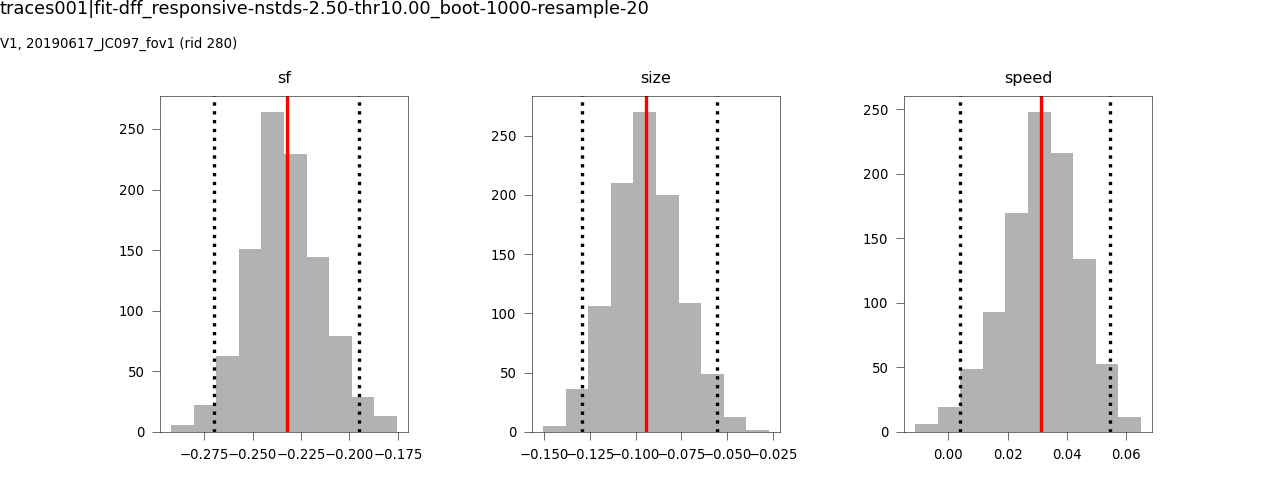

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics examples nonori_V1_20190617_JC097_fov1_rid280


In [179]:

pvals=[]
fig, axes = pl.subplots(1, 3, figsize=(8, 3))
for ax, param, ci_ in zip(axes.flat, ['sf', 'size', 'speed'], param_cis):
    iter_vs = iterd[param]
    ax.hist(iter_vs, color='k', alpha=0.3)
    reject_null = ~(ci_[0] < 0 < ci_[1])
    #ci_upper2 = np.percentile(ordered, alpha)
    true_v = float(true_[param])
    if reject_null:
        lcolor ='r'
    else:
        lcolor = 'k'
    ax.axvline(x=ci_[0], color='k', linestyle=':')
    ax.axvline(x=ci_[1], color='k', linestyle=':')
    ax.axvline(x=true_v, color=lcolor)
    ax.set_title(param)
    nonsig = ci_lower <= true_v<= ci_upper
    pvals.append(not nonsig)
fig.text(0, 0.9, '%s, %s (rid %i)' % (va, dk, rid))
pplot.label_figure(fig, data_id)
pl.subplots_adjust(wspace=0.5, hspace=0.8, top=0.8, bottom=0.1)

figname = 'nonori_%s_%s_rid%i' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, 'examples', '%s.svg' % figname))
print(curr_dst_dir, 'examples', figname)

In [181]:
true_

sf      -0.232310
size    -0.094366
speed    0.031167
dtype: float64

In [182]:
r_.loc[rid]

size    -0.094366
speed    0.031167
sf      -0.232310
Name: 280, dtype: float64

In [109]:
sf_lo, sz_lo, sp_lo = np.percentile(testd, (100-alpha)/2, axis=0)
sf_hi, sz_hi, sp_hi = np.percentile(testd, alpha+((100-alpha)/2), axis=0)
print(sf_lo, sz_lo, sp_lo)

-0.07162004857895753 -0.011886071667971395 -0.02623979624770266


In [101]:
sf_hi, sz_hi, sp_hi = np.percentile(testd, alpha+((100-alpha)/2), axis=0)

array([-0.05118127,  0.01001683, -0.00581061])

In [106]:
reject_null = (ci_lower < 0 < ci_upper)
reject_null

False

In [96]:
R = rdf.groupby(['cell']).apply(bootstrap_index_calculation, 
                            sdf=sdf, n_bootstrap_iters=100)

In [354]:
len(reliable_rois[reliable_rois==True].index.tolist())


60

In [355]:
len(rdf['cell'].unique())

65

In [332]:
rid = 0 #155 #280 #262 # Pref. sf=0.1
rd = rdf[rdf['cell']==rid].copy()

In [333]:
iters = bootstrap_nonori(rd)
is_r = is_reliable_or_no(rd, iters)
print(is_r)
# if is_r:
#     reliable_rois.append(rid)
        
        
# reliabe_=[]
# for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#     iter_vs = iters[(iters['size']==sz) & (iters['sf']==sf) & (iters['speed']==sp)]
#     ordered = sorted(iter_vs['response'])
#     ci_lower = np.percentile(ordered, (100-alpha)/2)
#     ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))
#     true_v =float(g['response'].mean())
#     r_val = ci_lower>0 and (ci_lower<true_v<ci_upper)
#     reliable_.append(r_val)
# if any(reliable_):
#     reliable_rois.append(rid)

True


In [283]:
figname = 'nonori_%s_%s_rid%i' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, 'examples', '%s.svg' % figname))
print(curr_dst_dir, 'examples', figname)

'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics'

In [325]:
p_ixs={}
for p in paramnames:
    lo, hi = rd[p].unique().min(), rd[p].unique().max()
    v1 = rd[rd[p]==lo]['response'].mean() 
    v2 = rd[rd[p]==hi]['response'].mean() 
    ix = (v1-v2)/(v1+v2) # +1 smaller preferred, -1 bigger val preferred
    p_ixs.update({p: ix})
pd.DataFrame(p_ixs, index=[rid])

,size,speed,sf
280,0.374773,-0.123779,0.922612


In [317]:
(v1-v2)/(v1+v2)

0.9226119166018091

In [318]:
rid

280